In [1]:
# ---------------------------------------------
# LIVER DISEASE MODEL TRAINING
# ---------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, classification_report, mean_squared_error, r2_score
)

from imblearn.over_sampling import SMOTE

In [3]:
# 1) Load dataset
df = pd.read_csv("D:\Guvi-Projects\Multiple Disease Project - 4\indian_liver_patient - indian_liver_patient.csv")   
display("Head:\n", df.head())
print("\nInfo:")
print(df.info())


<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\Akash Subramanian\AppData\Local\Temp\ipykernel_7064\1331965951.py:2: SyntaxWarning: invalid escape sequence '\G'
  df = pd.read_csv("D:\Guvi-Projects\Multiple Disease Project - 4\indian_liver_patient - indian_liver_patient.csv")


'Head:\n'

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
None


In [4]:
# 2) Inspect & handle missing values
print("\nNull counts before:", df.isnull().sum())


Null counts before: Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64


In [5]:
# Albumin_and_Globulin_Ratio often has missing values → fill with median
if 'Albumin_and_Globulin_Ratio' in df.columns:
    df['Albumin_and_Globulin_Ratio'] = pd.to_numeric(df['Albumin_and_Globulin_Ratio'], errors='coerce')
    df['Albumin_and_Globulin_Ratio'].fillna(df['Albumin_and_Globulin_Ratio'].median(), inplace=True)

# If any other numeric columns have nulls, fill median
num_cols = df.select_dtypes(include=['int64','float64']).columns
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c].fillna(df[c].median(), inplace=True)

# For any object columns (if present), fill mode
cat_cols = df.select_dtypes(include=['object']).columns
for c in cat_cols:
    df[c].fillna(df[c].mode()[0], inplace=True)

print("Null counts after:", df.isnull().sum())

Null counts after: Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64


C:\Users\Akash Subramanian\AppData\Local\Temp\ipykernel_7064\1461158572.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Albumin_and_Globulin_Ratio'].fillna(df['Albumin_and_Globulin_Ratio'].median(), inplace=True)
C:\Users\Akash Subramanian\AppData\Local\Temp\ipykernel_7064\1461158572.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

In [6]:
# 3) Target & Encoding
# The standard Indian Liver Patient dataset uses 'Dataset' as target: 1 = liver disease, 2 = no disease (or vice versa depending on source).
# We'll map: Dataset==1 -> 1 (has disease), Dataset==2 -> 0 (no disease)
if 'Dataset' in df.columns:
    df['Dataset'] = df['Dataset'].map({1: 1, 2: 0})
    target = 'Dataset'
else:
    raise ValueError("Target column 'Dataset' not found. Please check your CSV.")

# Encode Gender: Male->1, Female->0
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
else:
    print("Warning: 'Gender' column not found — skipping gender encoding.")

In [7]:
# 4) Quick EDA: class balance
print("\nClass distribution (before SMOTE):")
print(df[target].value_counts())
print(df[target].value_counts(normalize=True))



Class distribution (before SMOTE):
Dataset
1    416
0    167
Name: count, dtype: int64
Dataset
1    0.713551
0    0.286449
Name: proportion, dtype: float64


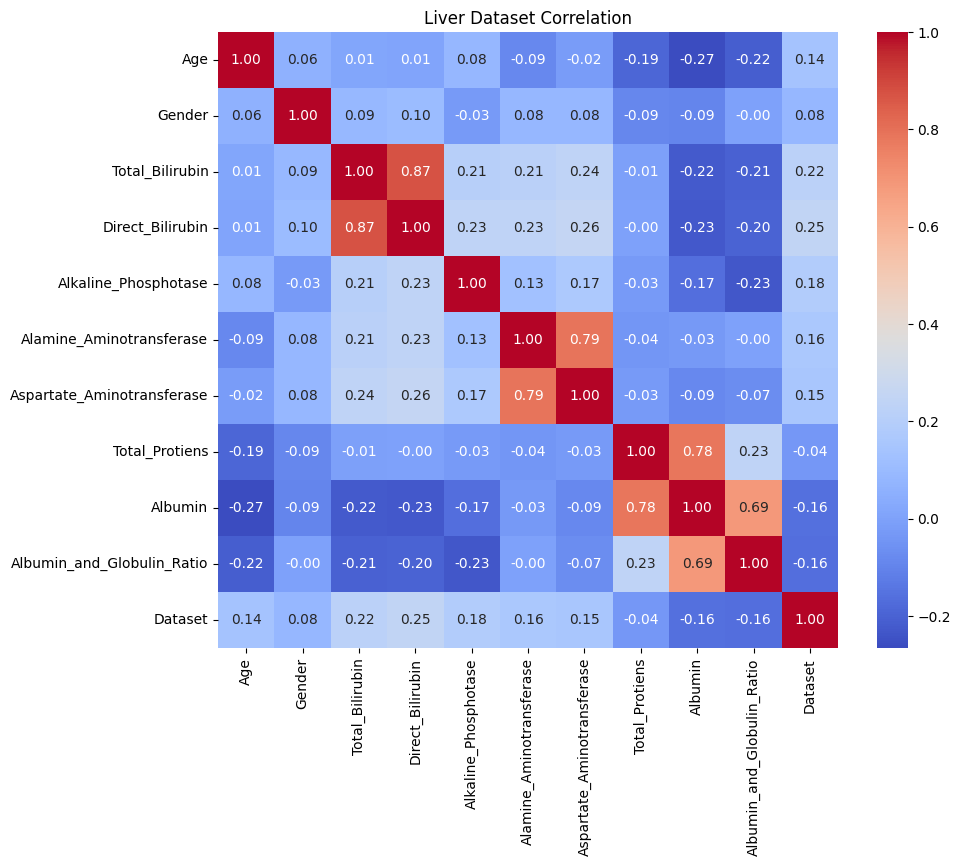

In [8]:
# Correlation heatmap with values
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Liver Dataset Correlation")
plt.show()

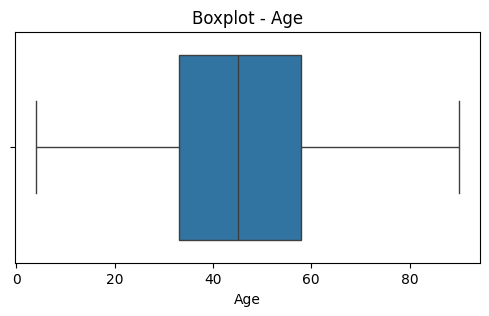

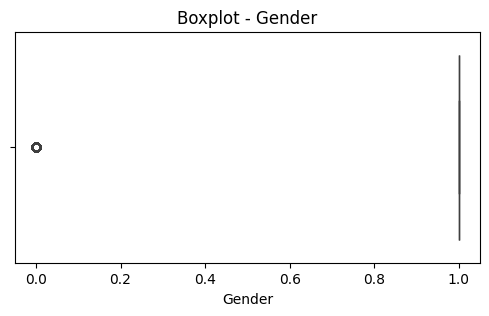

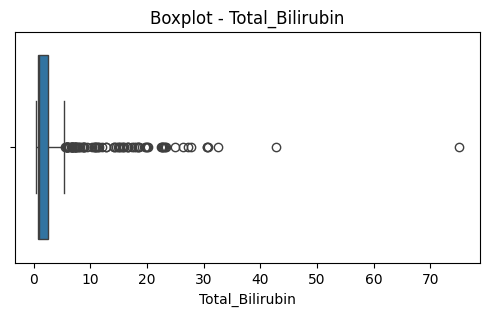

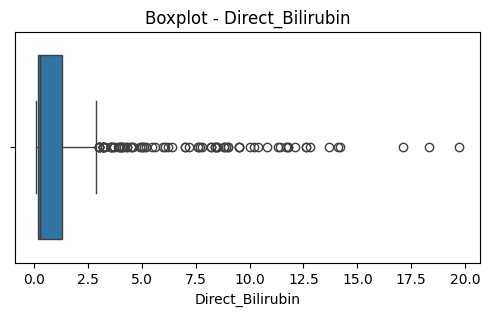

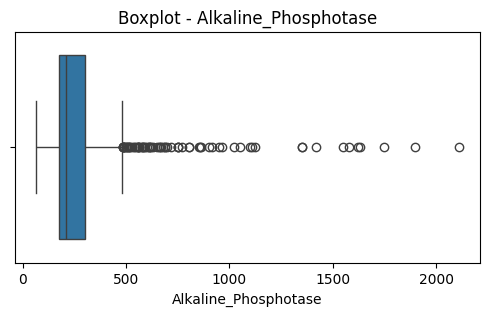

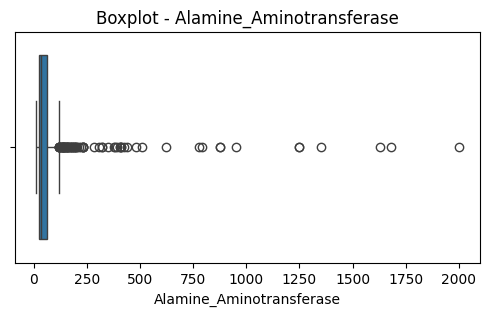

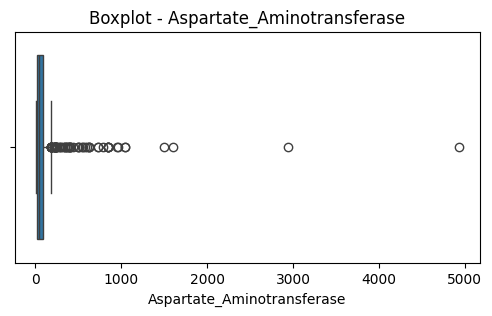

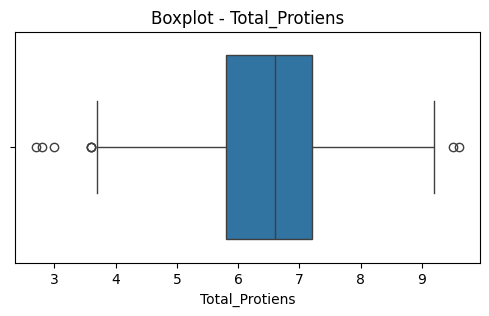

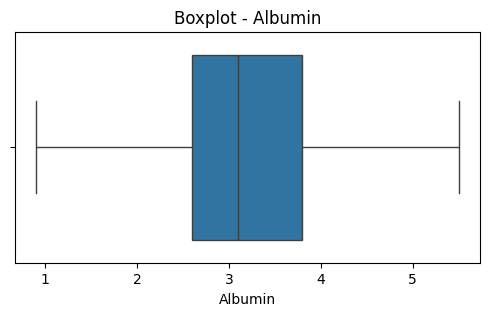

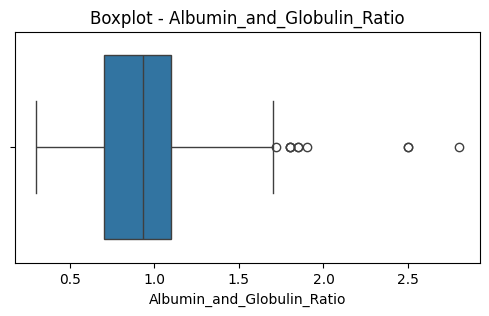

In [9]:
# Boxplots (optional): one-per-feature for clarity
features = [c for c in df.columns if c != target]
for col in features:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

In [10]:
# 5) Prepare X, y
X = df.drop(columns=[target])
y = df[target]


In [11]:
# 6) Balance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("\nAfter SMOTE class distribution:")
print(pd.Series(y_res).value_counts())



After SMOTE class distribution:
Dataset
1    416
0    416
Name: count, dtype: int64


In [12]:
# 7) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [13]:
# 8) Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
# 9) MODELING

# Linear Regression (as regressor -> thresholded for classification)
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin_cont = lin.predict(X_test)
y_pred_lin = (y_pred_lin_cont >= 0.5).astype(int)
print("\nLinear Regression -> MSE:", mean_squared_error(y_test, y_pred_lin_cont), "R2:", r2_score(y_test, y_pred_lin_cont))
print("Linear Regression Accuracy (thresholded):", accuracy_score(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin))


Linear Regression -> MSE: 0.20202945439203157 R2: 0.19185320517220716
Linear Regression Accuracy (thresholded): 0.7245508982035929
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        84
           1       0.75      0.67      0.71        83

    accuracy                           0.72       167
   macro avg       0.73      0.72      0.72       167
weighted avg       0.73      0.72      0.72       167



In [15]:
# Logistic Regression
log = LogisticRegression(max_iter=500)
log.fit(X_train, y_train)
y_pred_log = log.predict(X_test)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.7544910179640718
              precision    recall  f1-score   support

           0       0.72      0.83      0.77        84
           1       0.80      0.67      0.73        83

    accuracy                           0.75       167
   macro avg       0.76      0.75      0.75       167
weighted avg       0.76      0.75      0.75       167



In [20]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("\nKNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.7005988023952096
              precision    recall  f1-score   support

           0       0.66      0.85      0.74        84
           1       0.78      0.55      0.65        83

    accuracy                           0.70       167
   macro avg       0.72      0.70      0.69       167
weighted avg       0.72      0.70      0.69       167



In [21]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\nDecision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.7305389221556886
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        84
           1       0.76      0.67      0.71        83

    accuracy                           0.73       167
   macro avg       0.73      0.73      0.73       167
weighted avg       0.73      0.73      0.73       167



In [22]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8203592814371258
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        84
           1       0.85      0.77      0.81        83

    accuracy                           0.82       167
   macro avg       0.82      0.82      0.82       167
weighted avg       0.82      0.82      0.82       167




Top features:
 Alkaline_Phosphotase          0.155916
Aspartate_Aminotransferase    0.130414
Total_Bilirubin               0.118322
Alamine_Aminotransferase      0.117262
Age                           0.112127
Direct_Bilirubin              0.100787
Total_Protiens                0.081772
Albumin_and_Globulin_Ratio    0.081669
Albumin                       0.075383
Gender                        0.026347
dtype: float64


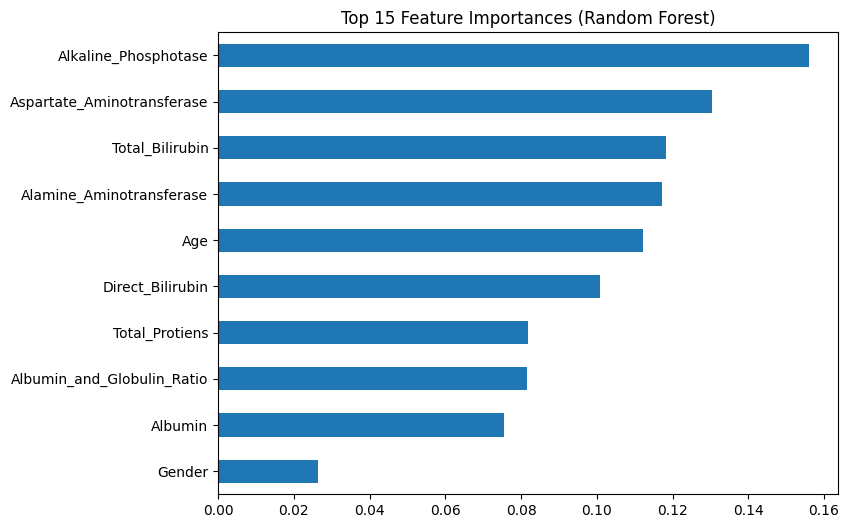

In [23]:
# 10) Feature importance from RandomForest
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop features:\n", feat_imp.head(15))

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

In [24]:
# 11) Save final RandomForest model and scaler
pickle.dump(rf, open("liver_model.pkl", "wb"))
pickle.dump(scaler, open("liver_scaler.pkl", "wb"))
print("\nLiver model and scaler saved as 'liver_model.pkl' and 'liver_scaler.pkl'")



Liver model and scaler saved as 'liver_model.pkl' and 'liver_scaler.pkl'
